In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import astropy 
#from astropy import units as u
#from astropy import constants as const

%matplotlib inline 
#for jupyter notebook

In [3]:
class Distribution():
    #redshift info
    low = np.array([])
    mean = np.array([])
    high = np.array([])
    #bin value
    value = np.array([])

    z_min = 0
    z_max = 4

    def __init__(self,filename, path="../load_nz/"):
        data =np.loadtxt(path+filename)
        self.low = data[:,0]
        self.mean = data[:,1]
        self.high = data[:,2]
        self.value = data[:,3]

    #interpolate result
    def interpolate(self, z):
        return np.interp(z, self.mean, self.value)
    def __call__(self, z):
        if(z< self.z_min or z > self.z_max): #seems to be never called since z in bin integral by definition >= zmin
            return 0
        return self.interpolate(z)

    #def resample():

    def devide_into_equal_bins(self, n=10, z_min=0, z_max=4):
        #cumulative distribution (possibly not the most accurate...)
        self.z_min = z_min 
        self.z_max = z_max
        mask = np.logical_and(self.mean>=z_min,  self.mean<=z_max)
        cumsum = np.cumsum(self.value[mask])
        step = cumsum[-1]/n
        bin_cuts = np.arange(0, cumsum[-1]+step, step)
        return np.interp(bin_cuts, cumsum, self.high[mask])#high is working better than mean (makes sense)
        # low_cuts = np.interp(bin_cuts, cumsum, self.low)
        # high_cuts = np.interp(bin_cuts, cumsum, self.high)
        # return low_cuts, high_cuts


#the naming here is maximally confusing but I think it is right this way around:
lenses = Distribution("zdistri_WFIRST_clustering_fine_bin.txt")
sources = Distribution("zdistri_WFIRST_lensing_fine_bin.txt")

Text(0.5, 0, 'redshift')

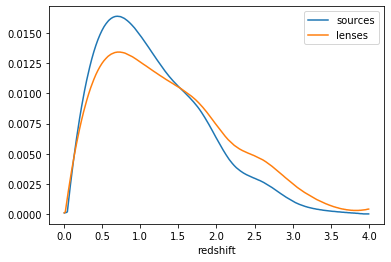

In [4]:
plt.plot(sources.mean, sources.value, label="sources")
plt.plot(lenses.mean, lenses.value, label="lenses")
plt.legend()
plt.xlabel("redshift")

In [5]:
from scipy import integrate
integrate.quad(lenses, 0, 4)

/Users/lwenzl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  


(0.026374012032903554, 1.360002221676565e-06)

In [6]:
lenses.devide_into_equal_bins()

array([0.01333   , 0.40890153, 0.61972515, 0.81697439, 1.020846  ,
       1.23989658, 1.47788827, 1.74037932, 2.06299616, 2.53974226,
       4.        ])

$$n^i_x(z_{\mathrm{ph}}) = \int_{z^i_{\mathrm{min},x}}^{z^i_{\mathrm{max},x}} dz \, n_{\mathrm{x}}(z) \, p^i\left(z_{\mathrm{ph}}|z,x\right)\,, $$

$$p^i\left(z_{\mathrm{ph}}|z,x\right) = \frac{1}{\sqrt{2\pi}\sigma_{z,x}(1+z)} \exp\left[-\frac{\left(z-z_{\mathrm{ph}} - \Delta^i_{z,x}\right)^2}{2\left(\sigma_{z,x}(1+z)\right)^2}\right]\,.$$



In [18]:
def calc_bins(equal_bins, distribution, sampling=np.linspace(0,4, 100), sigma = 0.01, Delta_i = 0.0): #need to make Delta_i an array!
    n_bins = len(equal_bins)-1
    bins = np.zeros((n_bins, len(sampling)))
    for i in range(n_bins):
        z_min = equal_bins[i]
        z_max = equal_bins[i+1]
        for zph_index in range(len(sampling)):
            p = P(sampling[zph_index], sigma, Delta_i)
            bins[i,zph_index ]  = integrate.quad(lambda z: distribution(z)*p(z), z_min, z_max)[0] 
        
    return bins, sampling
class P():
    zph = 0.
    sigma = 0.
    Delta_i = 0.
    def __init__(self,zph, sigma, Delta_i):
        self.zph = zph 
        self.sigma = sigma 
        self.Delta_i = Delta_i
    
    def set_z(zph):
        self.zph = zph
    def __call__(self,z):
        prefactor = 1/(np.sqrt(2*np.pi)*self.sigma*(1+z))
        expfactor = -1/(2*(self.sigma* (1+z))**2)
        return prefactor * np.exp(expfactor * (z - self.zph - self.Delta_i)*(z - self.zph - self.Delta_i))


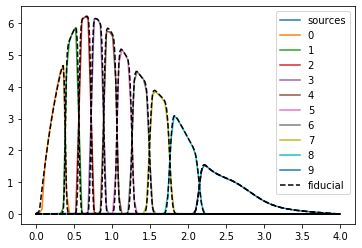

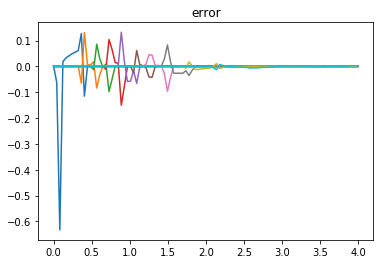

In [19]:
#full distribution
plt.plot(sources.mean, sources.value, label="sources")


sources_bins, z = calc_bins(sources.devide_into_equal_bins(z_min=0.08), sources, sigma = 0.01, Delta_i = 0.0)
sources_bins = sources_bins *380
for i in range(sources_bins.shape[0]):
    plt.plot(z, sources_bins[i,:], label=str(i))
# plt.yscale("log")
# plt.ylim(1, 10)



pathSOURCES = "../load_nz/WFIRST_zdist/original/WFIRST_zdist_sources_bin"
N_bins_SOURCES = 10

sources_old = {}
for i in range(N_bins_SOURCES):
    temp = np.loadtxt(pathSOURCES+str(i)+".txt")
    sources_old[i] = temp
for i in range(N_bins_SOURCES):
    plt.plot(sources_old[i][:,0], sources_old[i][:,1],"--", color="black")
plt.plot(sources_old[i][:,0], sources_old[i][:,1],"--", color="black", label="fiducial")
#for comparison the dataset from Cyrille
plt.legend()


plt.figure()
plt.title("error")
for i in range(sources_bins.shape[0]):
    plt.plot(z, sources_bins[i,:]- np.interp(z, sources_old[i][:,0], sources_old[i][:,1]), label=str(i))


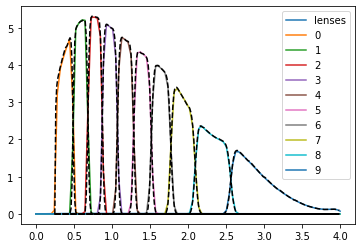

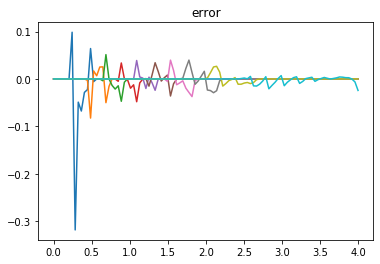

In [20]:
plt.plot(lenses.mean, lenses.value, label="lenses")

lenses_bins, z = calc_bins(lenses.devide_into_equal_bins(n=10, z_min=0.26), lenses, sigma = 0.01, Delta_i = 0.0)
lenses_bins = lenses_bins*395
for i in range(lenses_bins.shape[0]):
    plt.plot(z, lenses_bins[i,:], label=str(i))
# plt.yscale("log")
# plt.ylim(0.002, 0.02)
plt.legend()


pathLENSES = "../load_nz/WFIRST_zdist/original/WFIRST_zdist_lenses_bin"
N_bins_LENSES = 10

lenses_old = {}
for i in range(N_bins_LENSES):
    temp = np.loadtxt(pathLENSES+str(i)+".txt")
    lenses_old[i] = temp
for i in range(N_bins_LENSES):
    plt.plot(lenses_old[i][:,0], lenses_old[i][:,1],"--", color="black")

plt.figure()
plt.title("error")
for i in range(10):
    plt.plot(z, lenses_bins[i,:]- np.interp(z, lenses_old[i][:,0], lenses_old[i][:,1]), label=str(i))


** There must be some kind of lower redshift cutoff for the lensins one **
There indeed was: corrected in Tim's paper

In [21]:
%time calc_bins(lenses.devide_into_equal_bins(n=10, z_min=0.26), lenses, sigma = 0.01, Delta_i = 0.0)

CPU times: user 713 ms, sys: 5.13 ms, total: 718 ms
Wall time: 718 ms


(array([[1.18207836e-100, 1.20701269e-073, 4.85876279e-051,
         7.82882875e-033, 5.20134247e-019, 1.52783208e-009,
         2.49249360e-004, 8.17922163e-003, 9.90062579e-003,
         1.06595631e-002, 1.13162710e-002, 1.18580494e-002,
         7.93826035e-003, 1.22428176e-004, 2.88310907e-009,
         5.68575342e-017, 8.13351053e-028, 8.01563144e-042,
         5.31424337e-059, 2.34038520e-079, 6.79613785e-103,
         1.29510384e-129, 1.61403813e-159, 1.31174961e-192,
         6.93454311e-229, 2.37919629e-268, 5.28721698e-311,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+00

In [22]:
%time sources.devide_into_equal_bins(z_min=0.08)

CPU times: user 119 µs, sys: 7 µs, total: 126 µs
Wall time: 131 µs


array([0.09333   , 0.38833823, 0.56574499, 0.72743125, 0.89056042,
       1.06582924, 1.26319215, 1.492448  , 1.76139228, 2.14881889,
       4.        ])

In [80]:
# trying to make it faster

def calc_bins(equal_bins, distribution, sampling=np.linspace(0,4, 100), sigma = 0.01, Delta_i = 0.0): #need to make Delta_i an array!
    n_bins = len(equal_bins)-1
    bins = np.zeros((n_bins, len(sampling)))
    for i in range(n_bins):
        z_min = equal_bins[i]
        z_max = equal_bins[i+1]
        p = P(sampling[0], sigma, Delta_i)
        for zph_index in range(len(sampling)):
            p.set_z(sampling[zph_index])
            bins[i,zph_index ]  = integrate.quad(lambda z: distribution(z)*p(z), z_min, z_max, epsabs=1e-4, epsrel=1e-4)[0]
            #bins[i,zph_index ]  = integrate.romberg(lambda z: distribution(z)*p(z), z_min, z_max)
            
        print()
    return bins, sampling
class P():
    zph = 0.
    sigma = 0.
    Delta_i = 0.
    count = 0
    def __init__(self,zph, sigma, Delta_i):
        self.zph = zph 
        self.sigma = sigma 
        self.Delta_i = Delta_i
    
    def set_z(self,zph):
        self.zph = zph
    def __call__(self,z):
        self.count += 1
        prefactor = 1/(np.sqrt(2*np.pi)*self.sigma*(1+z))
        expfactor = -1/(2*(self.sigma* (1+z))**2)
        return prefactor * np.exp(expfactor * (z - self.zph - self.Delta_i)*(z - self.zph - self.Delta_i))


In [81]:
%time calc_bins(lenses.devide_into_equal_bins(n=10, z_min=0.26), lenses, sigma = 0.01, Delta_i = 0.0)











CPU times: user 446 ms, sys: 18.2 ms, total: 464 ms
Wall time: 451 ms


(array([[1.18207836e-100, 1.20701269e-073, 4.85876279e-051,
         7.82882875e-033, 5.20134247e-019, 1.52783208e-009,
         2.49248924e-004, 8.17920829e-003, 9.90067661e-003,
         1.06596282e-002, 1.13161821e-002, 1.18580388e-002,
         7.93829831e-003, 1.22427502e-004, 2.88310907e-009,
         5.68575342e-017, 8.13351053e-028, 8.01563144e-042,
         5.31424337e-059, 2.34038520e-079, 6.79613785e-103,
         1.29510384e-129, 1.61403813e-159, 1.31174961e-192,
         6.93454311e-229, 2.37919629e-268, 5.28721698e-311,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+00

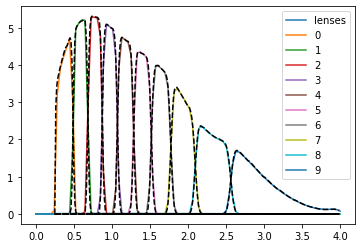

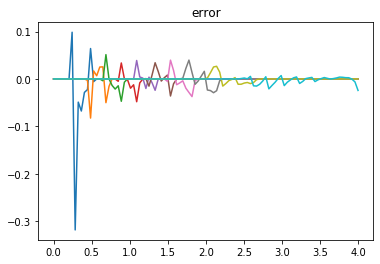

In [133]:
plt.plot(lenses.mean, lenses.value, label="lenses")

lenses_bins, z = calc_bins(lenses.devide_into_equal_bins(n=10, z_min=0.26), lenses, sigma = 0.01, Delta_i = 0.0)
lenses_bins = lenses_bins*395
for i in range(lenses_bins.shape[0]):
    plt.plot(z, lenses_bins[i,:], label=str(i))
# plt.yscale("log")
# plt.ylim(0.002, 0.02)
plt.legend()


pathLENSES = "../load_nz/WFIRST_zdist/original/WFIRST_zdist_lenses_bin"
N_bins_LENSES = 10

lenses_old = {}
for i in range(N_bins_LENSES):
    temp = np.loadtxt(pathLENSES+str(i)+".txt")
    lenses_old[i] = temp
for i in range(N_bins_LENSES):
    plt.plot(lenses_old[i][:,0], lenses_old[i][:,1],"--", color="black")

plt.figure()
plt.title("error")
for i in range(10):
    plt.plot(z, lenses_bins[i,:]- np.interp(z, lenses_old[i][:,0], lenses_old[i][:,1]), label=str(i))


In [134]:
a = lenses_bins[3,:]

In [135]:
lenses_bins[4,:] = a

## what about np.convolve
https://stackoverflow.com/questions/24148902/python-convolution-with-a-gaussian

In [138]:
for i in range(100):
    original_curve =lenses_bins[4,:]
    gx = np.linspace(0, 4, 100)
    sigma = 0.01
    gaussian = np.exp(-(gx/sigma)**2/2)
    result = np.convolve(original_curve, gaussian, mode="same")

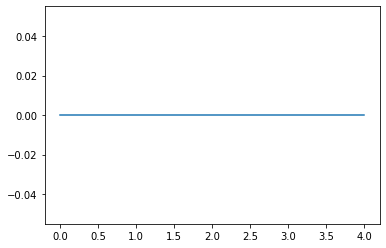

In [139]:
plt.plot(z, result )

In [95]:
z.shape

(400,)

In [96]:
result.shape

(499,)

Dear Rachel,

possibly a short email update will be sufficient for today?

I wrote Nick and Eanna concerning the special committee. Nick accepted! Yay. And I haven't heard back from Eanna yet, but Friday is not very long ago so hopefully he will still answer.

I have been working on a fast implementation of the binned redshift distribution calculations. Right now I am just loading the bin distributions from file but we want to marginalize over the redshift error as well. So far I can reproduce the distribtutions by calculation the integral directly but it is not fast enough. So now I am looking into using something better optimized since this is basically just a convolution with a modified gaussian. I am not there yet but making progress!

Also this weekend I have been quite busy moving my partner back to Buffalo and getting everything set up for the semester, so I am not quite as productive as I would like to be... By the end of the week that should be all done and I can go back to focusing on research again!

PS: the email from Cyrille today I think was written weeks ago, it probaly just was delayed in sending. 

Best
Lukas